# Coffea and Awkward

**March 15, 2023 at Beijing**

In [23]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods.base import NanoEventsArray
from imp import reload #每次修改调用函数后可以更新
import correctionlib, rich
import matplotlib.pyplot as plt
import sys
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

In [24]:
def load_event_dict(file_prefix, keys):
    # data_subkeys = ['photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'muon_mass','gmumu_mass','dr_lg','npvsGood','Rho_Calo','Rho_tracker']
    data_subkeys = ['muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'charge1','charge2','muon_mass']
    other_subkeys = data_subkeys + ['generator_weight', 'event_weight']#'LHEPdfWeight','LHEScaleWeight'
    
    event_dict = {}
    for key in keys:
        subkeys = other_subkeys if 'data' not in key else data_subkeys
        event_dict[key] = {}
        for subkey in subkeys:
            event_dict[key][subkey] = ak.from_parquet(f'{file_prefix}_{key}_{subkey}.parquet')
    return event_dict

In [25]:
keys = ['dataF', 'dataG', 'zg0', 'zg1', 'zg2','zg3','tt', 'zz', 'ww', 'wz']  # 根据你的实际键来修改这个列表
#keys = ['zg', 'tt', 'zz', 'ww', 'wz']  # 根据你的实际键来修改这个列表
#keys = ['dataC', 'dataD']
# keys = ['zg0', 'zg1', 'zg2','zg3','zz', 'ww', 'wz']
# keys = ['zg0']
# 读取数据
event_final = load_event_dict('../selection_file/event_final', keys)


In [26]:
event_final

{'dataF': {'muon1_pt': <Array [55.9, 158, 61.3, ... 45.4, 71.6, 71.7] type='3522 * ?float32'>,
  'muon2_pt': <Array [24.8, 36.5, 24.2, ... 29.2, 66.3, 28.8] type='3522 * ?float32'>,
  'muon1_eta': <Array [-0.129, -0.552, 0.313, ... 1.63, 0.155] type='3522 * ?float32'>,
  'muon2_eta': <Array [0.974, -0.421, 1.66, ... 2.26, -0.252] type='3522 * ?float32'>,
  'charge1': <Array [-1, 1, 1, -1, 1, ... 1, 1, 1, -1, -1] type='3522 * ?int32'>,
  'charge2': <Array [1, -1, -1, 1, -1, ... -1, -1, -1, 1, 1] type='3522 * ?int32'>,
  'muon_mass': <Array [80.3, 90.9, 91.6, ... 84.7, 91.2, 90.5] type='3522 * ?float32'>},
 'dataG': {'muon1_pt': <Array [65.1, 64.9, 56.1, ... 63.3, 54.4, 50.1] type='581 * ?float32'>,
  'muon2_pt': <Array [34.2, 36.5, 31.6, ... 39.4, 34.1, 25.4] type='581 * ?float32'>,
  'muon1_eta': <Array [0.0444, 0.782, ... -0.987, -1.17] type='581 * ?float32'>,
  'muon2_eta': <Array [0.812, -0.349, ... -0.142, 0.242] type='581 * ?float32'>,
  'charge1': <Array [-1, 1, -1, 1, 1, ... 1, 

In [27]:
# 将 "data1", "data2", "data3", "data4" 这四个 key 的内容合并为 "data" 这个 key
data_keys = ["dataF", "dataG"]
event_final["data"] = {}

info_keys = list(event_final["dataF"].keys())

# 遍历每个信息键
for info_key in info_keys:
    # 从 event_final 中提取 "data1", "data2", "data3", "data4" 这四个 key 的数据
    data_to_concatenate = [event_final[data_key][info_key] for data_key in data_keys]

    # 使用 ak.concatenate 将数据连接在一起
    event_final["data"][info_key] = ak.concatenate(data_to_concatenate)



In [28]:
del event_final["dataF"]
del event_final["dataG"]
event_final

{'zg0': {'muon1_pt': <Array [52.6, 101, 56.1, ... 52.9, 80.1, 91.1] type='92130 * ?float32'>,
  'muon2_pt': <Array [38.8, 79.1, 45.2, ... 36.2, 62.5, 32.2] type='92130 * ?float32'>,
  'muon1_eta': <Array [-0.767, -0.379, 1.66, ... 0.891, 0.429] type='92130 * ?float32'>,
  'muon2_eta': <Array [-1.88, -0.966, 1.59, ... 1.64, 0.167] type='92130 * ?float32'>,
  'charge1': <Array [-1, 1, -1, -1, 1, ... 1, -1, -1, 1, 1] type='92130 * ?int32'>,
  'charge2': <Array [1, -1, 1, 1, -1, ... -1, 1, 1, -1, -1] type='92130 * ?int32'>,
  'muon_mass': <Array [94.6, 90.4, 97.7, ... 81.8, 81.8, 90.7] type='92130 * ?float32'>,
  'generator_weight': <Array [-1, 1, 1, 1, 1, 1, ... 1, 1, 1, -1, 1] type='92130 * ?float32'>,
  'event_weight': <Array [1, 1, 1, 1, 1, -1, ... 1, 1, -1, -1, 1] type='93358877 * float32'>},
 'zg1': {'muon1_pt': <Array [86.5, 59.2, 85.7, ... 163, 51.6, 51.4] type='1081280 * ?float32'>,
  'muon2_pt': <Array [42.9, 32.4, 37.8, ... 38.1, 44.3, 45.7] type='1081280 * ?float32'>,
  'muon1_

# plot weight

In [7]:
#BKG = {'zg1', 'zg2','zg3'}
BKG = {'zg0','zg1', 'zg2','zg3','tt', 'zz', 'wz', 'ww','nonpromptCD'} #nonpromptCD
#BKG = {'tt', 'zz', 'wz', 'ww','nonprompt'}
#SIG = {'zg'}
# LUMI unit is fb
LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83, "2022CD": 6.36,"2022FG": 21.6,"2022EFG": 39.22}
XSEC = {
    # unit is pb^-1
#    'zg': 62.3,#run2 55.48
    'zg0': 124.6,
    'zg1': 1.74,#27.11
    'zg2': 0.30,#0.88,
    'zg3': 0.042,#0.073,
    'tt': 96.9,#101.78,
    'ww': 116.8,#80.27,
    'wz': 54.3,#29.14,
    'zz': 16.7,#12.83,
}

In [8]:
weight = {
    i: (
        1299.91/386 if i == 'nonpromptCD' else#1128 333.19 980 1299.91
#        fake_photon_weights if i == 'nonprompt' else
        (
#            correction.evaluate(np.array(event_final[i]['nPU']), "nominal") *
#            all_pileup_weights[i] *
            np.sign(event_final[i]['generator_weight']) * XSEC[i] * LUMI['2022FG'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final if i != 'data'
}

## Plot

In [9]:
event_final_2 = {
    # 'data':event_final['data'],
    # 'tt':event_final['tt'],
    'ww':event_final['ww'],
    'wz':event_final['wz'],
    'zz':event_final['zz'],
    # 'nonpromptCD':event_final['nonpromptCD'],
    'zg0':event_final['zg0'],
    'zg1':event_final['zg1'],
    'zg2':event_final['zg2'],
    'zg3':event_final['zg3'],
}

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

#weight={y: {c: events[y][c].event_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}


In [13]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter
import seaborn as sns


LUMI_UNCERTAINTY = 0.024

hep.style.use("CMS")
#mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab20").colors)
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
#    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    rlabel_content = f'{LUMI[year]} $fb^{{-1}}$  {year} (13.6 TeV)'
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, llabel='Preliminary', rlabel=rlabel_content)
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
########
#    bkg_total_err = error_bar(np.sqrt(bkg_total_err), bkg_total_err, type='mc')
    bkg_total_err = np.zeros(bins)



    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)


        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)

        if k == 'nonpromptCD':
            stacked['h'][k] = h
            stacked['var'][k] = var
            var += (0.0508 * h)**2 #0.3034
            bkg_total_err += var
        
        if (k in BKG) & ('nonprompt' not in k): 
            stacked['h'][k] = h
            stacked['var'][k] = var
#######
            bkg_total_err += var
        else:
            individual['h'][k] = h
            individual['var'][k] = var

#######
    bkg_total_err = np.sqrt(bkg_total_err)

    ## plot
#    SIG_COLOR={'zg': 'red'}
    # 创建颜色映射
    #colors = ['blue','sienna','salmon','orange','gold','yellow']'light green','light rose''pale peach',
#    colors = ['dark','very light brown','powder pink','light grey green','light blue','apricot','faded yellow','brown']#'bright sky blue','sea blue','sky'
    colors = ['dark','sea blue','neon blue','fern','light green','orange yellow']#muted green
    # colors = ['orange yellow']
    color_dict = {}
    color_idx = 0
    for key in arrays.keys():
        if 'zg' in key:
            color_dict[key] = 'yellow'
        else:
            color_dict[key] = sns.xkcd_rgb[colors[color_idx]]
            color_idx += 1

    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        #hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax, color='red')
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)

    #   绘制 MC 统计不确定性的阴影区域
        x_centers = (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:]) / 2
        x_extended = np.concatenate(([x_centers[0] - (x_centers[1] - x_centers[0])], x_centers, [x_centers[-1] + (x_centers[-1] - x_centers[-2])]))
        bkg_h_extended = np.concatenate(([bkg_h[0]], bkg_h, [bkg_h[-1]]))
        bkg_total_err_extended = np.concatenate(([bkg_total_err[0]], bkg_total_err, [bkg_total_err[-1]]))
        # ax.fill_between(x_extended, bkg_h_extended - bkg_total_err_extended, bkg_h_extended + bkg_total_err_extended, facecolor='none', edgecolor='black', hatch='////', linewidth=0.0, alpha=0.8, step='mid', label='MC stat. unc.')
        
    # 添加lumi不确定性
        lumi_uncertainty = 0.024
        total_uncertainty = np.sqrt(bkg_total_err**2 + (lumi_uncertainty * bkg_h)**2)
        total_uncertainty_extended = np.concatenate(([total_uncertainty[0]], total_uncertainty, [total_uncertainty[-1]]))
        ax.fill_between(x_extended, bkg_h_extended - total_uncertainty_extended, bkg_h_extended + total_uncertainty_extended, facecolor='none', edgecolor='black', hatch='////', linewidth=0.0, alpha=0.8, step='mid', label='Total unc.')
        
     
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    if not density:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    
    # 统计误差+系统误差（lumi）
    relative_total_err = total_uncertainty / bkg_h
    ax1.fill_between(x_centers, 1 - relative_total_err, 1 + relative_total_err, color='gray', alpha=0.5, step='mid', label='Total unc.')

#统计误差表示
    #relative_bkg_err = bkg_total_err / bkg_h
    # ax1.fill_between(x_centers, 1 - relative_bkg_err, 1 + relative_bkg_err, color='gray', alpha=0.5, step='mid', label='MC stat. unc.')


    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    handles, labels = ax.get_legend_handles_labels()
    handled_labels = []
    handled_handles = []
    for handle, label in zip(handles, labels):
        if 'zg' in label and 'zg' not in handled_labels:
            handled_labels.append('zg')
            handled_handles.append(handle)
        elif 'zg' not in label:
            handled_labels.append(label)
            handled_handles.append(handle)
    ax.legend(handled_handles, handled_labels, loc="best", ncol=3, frameon=False, fontsize=15)

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.show()

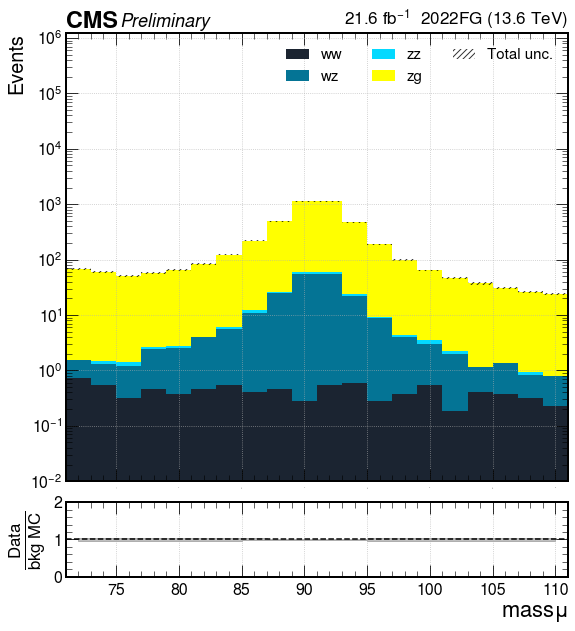

In [16]:
#tesing plot
arrays={
    k: event_final_2[k]['muon_mass'] for k in event_final_2
#    k: event_final_2[k]['photon_pt'][:,0] for k in event_final_2 
}
data_mc_compare_plot(arrays, weight=weight, plot_name='mass_muon', x_name=r'$mass \mu$', x_max=111, x_min=71, bins=20, year='2022FG', density=True,overflow=True)
# data_mc_compare_plot(arrays, weight=weight, plot_name='photon_pt', x_name=r'$Pt (\gamma)$', x_max=450, x_min=100, bins=7, year='2022FG', density=True,overflow=True)

### 保存root

In [40]:
import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [71, 76, 81,86,91,96,101,106,111]
bins = [100,150,200,250, 300, 350, 400, 450]
#250, 300, 350, 400, 450]
# 创建ROOT文件
with uproot.recreate("datacard.root") as f:
    
    zg_combined_data = []  # 存放所有zg样本的数据
    zg_combined_weights = []  # 存放所有zg样本的权重

    # 对于event_final_2中的每个key
    for key, values in event_final_2.items():
        if key == 'data':
            continue

        # 对于zg样本，将它们的数据和权重存储在列表中以便后续合并
        if key.startswith("zg"):
            # zg_combined_data.extend(values['muon_mass'])
            zg_combined_data.extend(values['photon_pt'][:, 0])
            zg_combined_weights.extend(weight[key])
            continue

        # 将所有大于等于450的数据点都设置为450
        # data_to_fill = np.where(values['muon_mass'] >= 111, 110.9, values['muon_mass'])
        data_to_fill = np.where(values['photon_pt'][:, 0] >= 450, 449.9, values['photon_pt'][:, 0])
        
        # 创建boost_histogram直方图，并明确指定使用underflow和overflow bins
        hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
        
        # 使用photon_pt和对应的权重填充直方图
        hist.fill(data_to_fill, weight=weight[key])
        
        # 将boost_histogram直方图转换为TH1并保存到ROOT文件中
        f[f"{key}_central_value"] = hist.to_numpy()
    
    # 对zg样本进行捏合并保存
    zg_combined_data = np.where(np.array(zg_combined_data) >= 450, 449.9, np.array(zg_combined_data))
    zg_hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
    zg_hist.fill(zg_combined_data, weight=np.array(zg_combined_weights))
    f["zg_central_value"] = zg_hist.to_numpy()


In [41]:
import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [71, 76, 81,86,91,96,101,106,111]
bins = [100, 150, 200, 250, 300, 350, 400, 450]

# 创建ROOT文件
with uproot.update("datacard.root") as f:

    # 对于event_final_2中的每个key
    for key, values in event_final_2.items():
        if key != 'data':
            continue

        # 将所有大于等于450的数据点都设置为450
        data_to_fill = np.where(values['photon_pt'][:, 0] >= 450, 449.9, values['photon_pt'][:, 0])
        # data_to_fill = np.where(values['muon_mass'] >= 111, 110.9, values['muon_mass'])
        
        # 创建boost_histogram直方图，并明确指定使用underflow和overflow bins
        hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
        
        # 使用photon_pt和对应的权重填充直方图
        hist.fill(data_to_fill)
        
        # 将boost_histogram直方图转换为TH1并保存到ROOT文件中
        f[f"{key}_central_value"] = hist.to_numpy()



## 出图

/tmp/ipykernel_122661/190961332.py:149: RuntimeWarning: invalid value encountered in true_divide
  relative_total_err = total_uncertainty / bkg_h


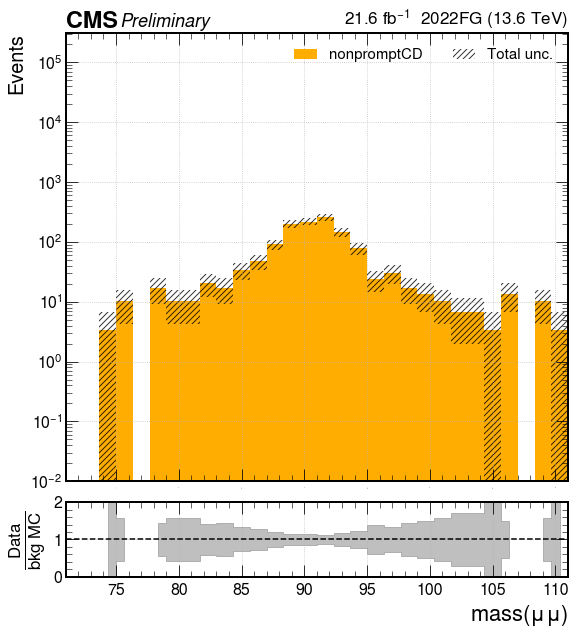

/tmp/ipykernel_122661/190961332.py:149: RuntimeWarning: invalid value encountered in true_divide
  relative_total_err = total_uncertainty / bkg_h


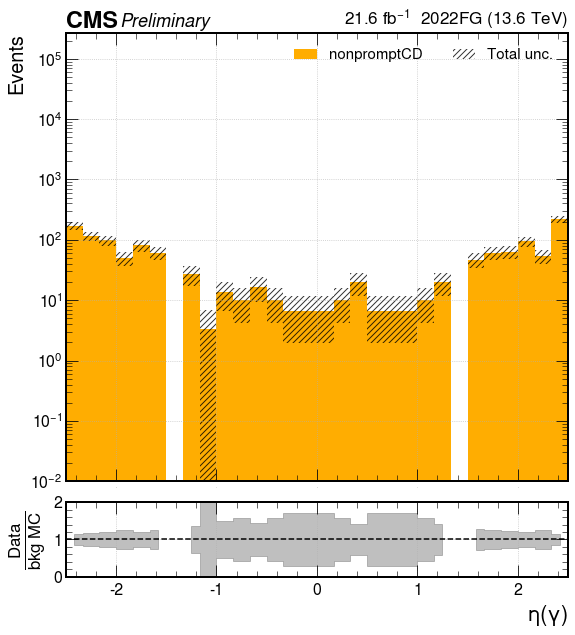

/tmp/ipykernel_122661/190961332.py:149: RuntimeWarning: invalid value encountered in true_divide
  relative_total_err = total_uncertainty / bkg_h


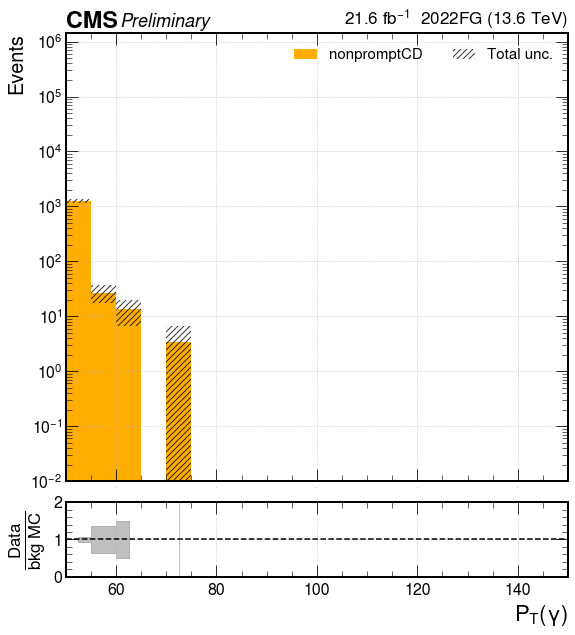

/tmp/ipykernel_122661/190961332.py:149: RuntimeWarning: invalid value encountered in true_divide
  relative_total_err = total_uncertainty / bkg_h


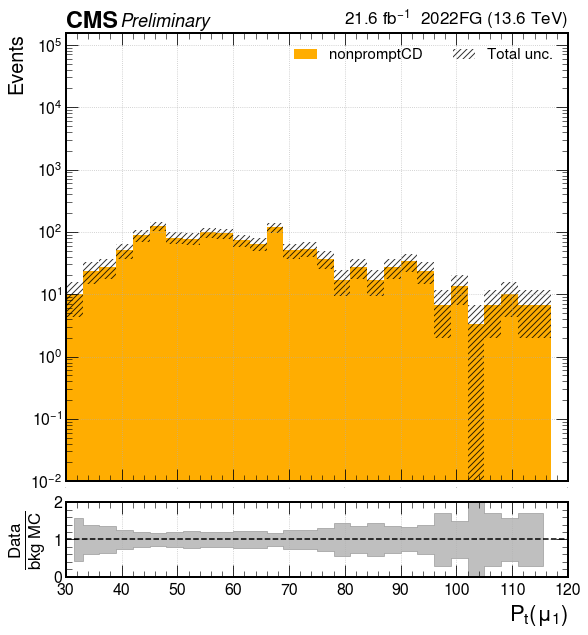

/tmp/ipykernel_122661/190961332.py:149: RuntimeWarning: invalid value encountered in true_divide
  relative_total_err = total_uncertainty / bkg_h


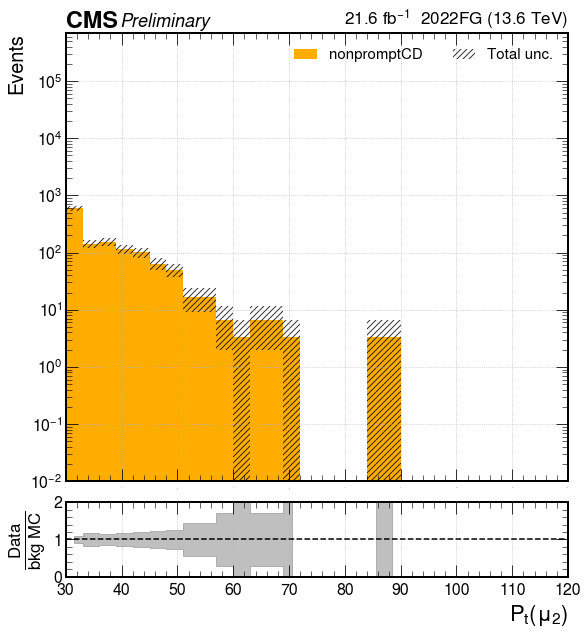

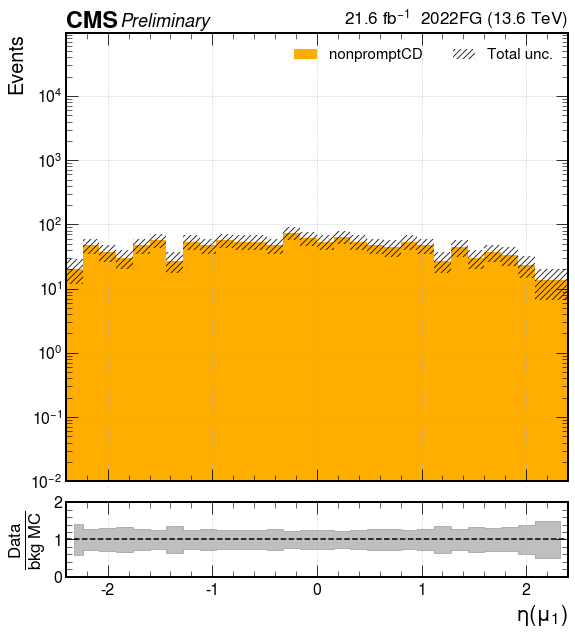

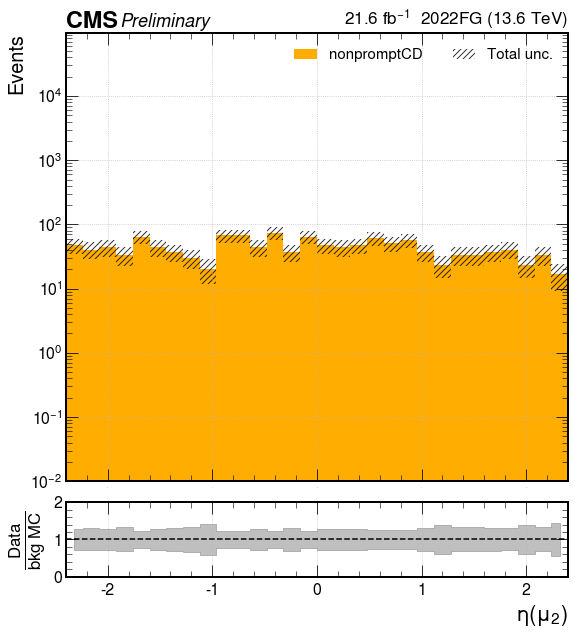

In [80]:
#plot all
plot_info = [
    ('muon_mass', r'$mass (\mu \mu)$', 'muon_mass', 71, 111, 30, False),
    # ('gmumu_mass', r'$mass (\mu \mu \gamma)$', 'gmumu_mass', 85, 110, 20, False),
    ('photon_eta', r'$\eta (\gamma)$', 'photon_eta', -2.5, 2.5, 30, True),
    ('photon_pt', r'$P_T (\gamma)$', 'photon_pt', 50, 150, 20, True),
    ('muon1_pt', r'$P_t (\mu_1)$', 'muon1_pt', 30, 120, 30, False),
    ('muon2_pt', r'$P_t (\mu_2)$', 'muon2_pt', 30, 120, 30, False),
    ('muon1_eta', r'$\eta (\mu_1)$', 'muon1_eta', -2.4, 2.4, 30, False),
    ('muon2_eta', r'$\eta (\mu_2)$', 'muon2_eta', -2.4, 2.4, 30, False),
    # ('dr_lg',r'$\delta R(l\gamma)$','dr_lg',0.5, 1.5, 30, True)
]

for plot_name, x_name, var_name, x_min, x_max, bins, is_photon in plot_info:
    arrays = {k: event_final_2[k][var_name] for k in event_final_2}
    if is_photon:
        arrays = {k: v[:, 0] for k, v in arrays.items()}
    
    data_mc_compare_plot(arrays, weight=weight, plot_name=plot_name, x_name=x_name, x_min=x_min, x_max=x_max, bins=bins, year='2022FG', density=True, underflow=True,overflow=False)


## FSR

/tmp/ipykernel_1941593/1032871220.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('white')


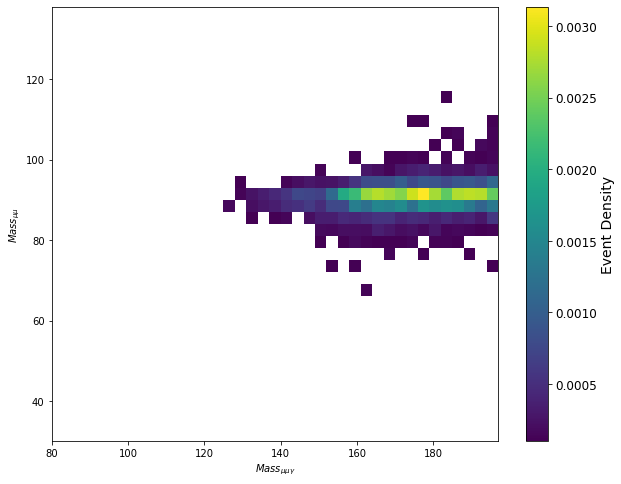

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# 创建二维直方图
plt.figure(figsize=(10, 8))

# 使用归一化的方式
#counts, xedges, yedges, im = plt.hist2d(event_final['data']['gmumu_mass'],event_final['data']['muon_mass'], 
counts, xedges, yedges, im = plt.hist2d(event_final['zg1']['gmumu_mass'],event_final['zg1']['muon_mass'], 
                                        bins=[np.arange(80, 200, 3), np.arange(30, 140, 3)], 
                                        cmap='viridis', density=True)

# 创建一个新的colormap，将密度为0的部分设为白色
cmap = plt.cm.viridis
cmap.set_under('white')

# 使用新的colormap
im.set_cmap(cmap)

# 为图像设置最小可见值（小于这个值的部分将被cmap的set_under方法影响）
im.set_clim(0.0001)

# 显示色标
cbar = plt.colorbar(im, label='Event Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Event Density', size=14)

plt.xlabel('$Mass_{\mu\mu\gamma}$')
plt.ylabel('$Mass_{\mu\mu}$')

plt.show()


/tmp/ipykernel_205944/4262816858.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('white')


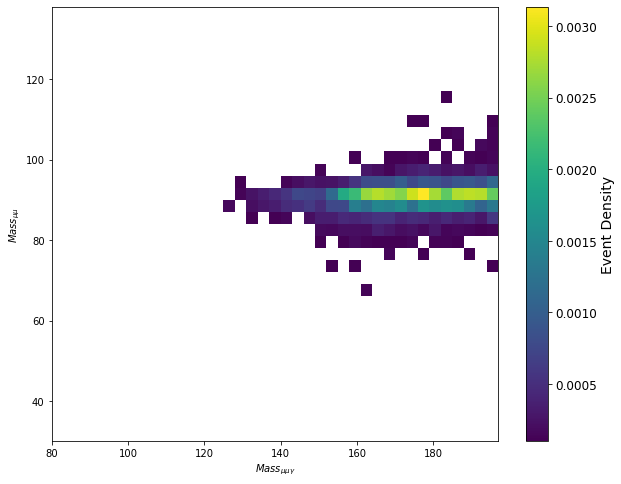

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# 创建一个布尔数组，其中满足条件的位置是True，不满足的是False
mask = ak.any(event_final['zg1']['pdgid']==22,axis=1)

# 创建二维直方图
plt.figure(figsize=(10, 8))

# 使用归一化的方式
counts, xedges, yedges, im = plt.hist2d(event_final['zg1']['gmumu_mass'][mask], event_final['zg1']['muon_mass'][mask], 
                                        bins=[np.arange(80, 200, 3), np.arange(30, 140, 3)], 
                                        cmap='viridis', density=True)

# 创建一个新的colormap，将密度为0的部分设为白色
cmap = plt.cm.viridis
cmap.set_under('white')

# 使用新的colormap
im.set_cmap(cmap)

# 为图像设置最小可见值（小于这个值的部分将被cmap的set_under方法影响）
im.set_clim(0.0001)

# 显示色标
cbar = plt.colorbar(im, label='Event Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Event Density', size=14)

plt.xlabel('$Mass_{\mu\mu\gamma}$')
plt.ylabel('$Mass_{\mu\mu}$')

plt.show()


/tmp/ipykernel_1941593/1747067208.py:36: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('white')


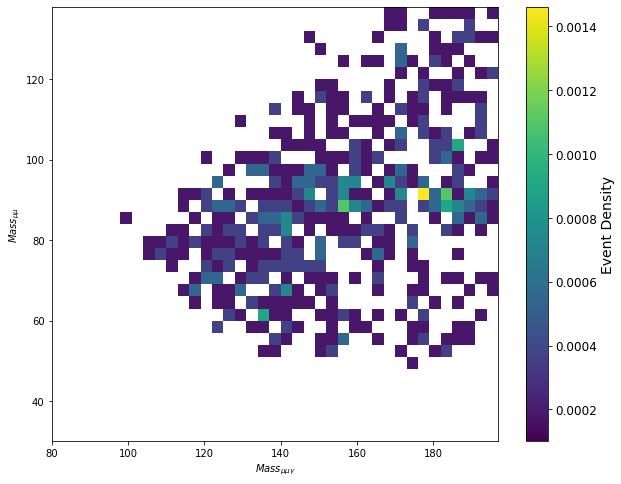

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import awkward as ak

# 创建二维直方图
plt.figure(figsize=(10, 8))

# 待绘制的样本列表
keys_to_plot = ['zg1', 'zg2', 'zg3', 'tt', 'zz', 'ww', 'wz']

# 初始化两个空的列表，用于存放所有样本的gmumu_mass和muon_mass数据
all_gmumu_mass = []
all_muon_mass = []

for key in keys_to_plot:
    current_data = event_final[key]
    
    pdg_ids = current_data['pdgid'][current_data['MotherIdx'][current_data['photonIdx']]]
    mask = (np.abs(pdg_ids) == 11) | (np.abs(pdg_ids) == 13)
    test = ak.flatten(mask)
    
    gmumu_mass = ak.to_numpy(current_data['gmumu_mass'][test])
    muon_mass = ak.to_numpy(current_data['muon_mass'][test])
    
    all_gmumu_mass.extend(gmumu_mass)
    all_muon_mass.extend(muon_mass)

# 使用归一化的方式绘制所有样本的数据
counts, xedges, yedges, im = plt.hist2d(all_gmumu_mass, all_muon_mass, 
                                        bins=[np.arange(80, 200, 3), np.arange(30, 140, 3)], 
                                        cmap='viridis', density=True)

# 创建一个新的colormap，将密度为0的部分设为白色
cmap = plt.cm.viridis
cmap.set_under('white')

# 使用新的colormap
im.set_cmap(cmap)

# 为图像设置最小可见值（小于这个值的部分将被cmap的set_under方法影响）
im.set_clim(0.0001)

# 显示色标
cbar = plt.colorbar(im, label='Event Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Event Density', size=14)

plt.xlabel('$Mass_{\mu\mu\gamma}$')
plt.ylabel('$Mass_{\mu\mu}$')

plt.show()


## FSR contamination

In [ ]:
keys = ['dataC', 'dataD', 'zg1', 'zg2','zg3','tt', 'zz', 'ww', 'wz']  # 根据你的实际键来修改这个列表
#keys = ['zg', 'tt', 'zz', 'ww', 'wz']  # 根据你的实际键来修改这个列表
#keys = ['dataC', 'dataD']
# 读取数据
# event_final = load_event_dict('selection_file/event_final', keys)
event_final = load_event_dict('selection_fsrfile/event_final', keys)


In [ ]:
#一次溯源

# 定义样本keys
keys = ['zg1', 'zg2', 'zg3']
# keys = ['zg1', 'zg2', 'zg3', 'tt', 'zz', 'ww', 'wz']

# 用于存储所有样本数据的列表
all_data = []

for key in keys:
    # 转换awkward array到numpy array并添加到总数据列表中
    numpy_array = ak.to_numpy(ak.flatten(event_final[key]['pdgid'][event_final[key]['MotherIdx'][event_final[key]['photonIdx']]]))
    all_data.extend(numpy_array)

# 转换数据列表为numpy数组
all_data = np.array(all_data)

# 获取最大值和最小值
min_val, max_val = int(np.min(all_data)), int(np.max(all_data))

# 创建一个数组，该数组的每个元素都是一个bin的边缘
bins = np.arange(min_val, max_val+2)  # +2 to include max_val in the bins

# 创建直方图并获取返回值
counts, bin_edges = np.histogram(all_data, bins=bins)

# 打印每个bin的边界和对应的计数
for i in range(len(counts)):
    if counts[i] > 0:
        print(f"Bin at {int(bin_edges[i])}: {counts[i]} counts")

# 创建直方图
# plt.hist(all_data, bins=bins)
# plt.xlabel('pdgid')
# plt.ylabel('Counts')
# plt.show()


Bin at -511: 1 counts
Bin at -423: 2 counts
Bin at -421: 3 counts
Bin at -413: 2 counts
Bin at -411: 2 counts
Bin at -13: 6 counts
Bin at -11: 3 counts
Bin at -4: 2 counts
Bin at -2: 2 counts
Bin at -1: 1 counts
Bin at 1: 23 counts
Bin at 2: 16 counts
Bin at 3: 14 counts
Bin at 4: 2 counts
Bin at 13: 4 counts
Bin at 15: 1 counts
Bin at 21: 3 counts
Bin at 22: 30636 counts
Bin at 23: 1153 counts
Bin at 111: 10 counts
Bin at 213: 1 counts
Bin at 221: 1 counts
Bin at 223: 1 counts
Bin at 323: 1 counts
Bin at 411: 1 counts
Bin at 413: 1 counts
Bin at 421: 1 counts
Bin at 423: 3 counts


In [ ]:
# keys_to_plot = ['zg1', 'zg2', 'zg3']
keys_to_plot = ['zg2']
colors = ['b', 'g', 'r']


for key, color in zip(keys_to_plot, colors):
    current_data = event_final[key]
    
    mother1_pdg_ids = current_data['pdgid'][current_data['MotherIdx'][current_data['photonIdx']]]
    mask1 = (np.abs(mother1_pdg_ids) == 13)
    mask2 = current_data['gmumu_mass'] < 200
    final_mask = ak.flatten(mask1 & mask2 )
    photonIdx = current_data['photonIdx'][final_mask]
    all_pdgid = current_data['pdgid'][final_mask][0]
    all_motheridx = current_data['MotherIdx'][final_mask][0]
    # print('photonIdx',current_data['photonIdx'][final_mask])
    # print('all pdgid',current_data['pdgid'][final_mask])
    # print('all motheridx',current_data['MotherIdx'][final_mask])
    # print('photon pdgid',current_data['pdgid'][current_data['photonIdx']][final_mask])
    # #print('mother particle index of photon',current_data['MotherIdx'][current_data['photonIdx']][final_mask])
    # print('mother particle pdgid of photon',current_data['pdgid'][current_data['MotherIdx'][current_data['photonIdx']]][final_mask])



In [ ]:
import awkward as ak

# 创建PDG ID到粒子名称的映射
pdg_to_name = {
    1: 'd', -1: 'anti-d',
    2: 'u', -2: 'anti-u',
    3: 's', -3: 'anti-s',
    4: 'c', -4: 'anti-c',
    5: 'b', -5: 'anti-b',
    6: 't', -6: 'anti-t',
    11: 'e-', -11: 'e+',
    12: 'nu_e', -12: 'anti-nu_e',
    13: 'mu-', -13: 'mu+',
    14: 'nu_mu', -14: 'anti-nu_mu',
    15: 'tau-', -15: 'tau+',
    16: 'nu_tau', -16: 'anti-nu_tau',
    21: 'g',
    22: 'gamma',
    23: 'Z',
    24: 'W+', -24: 'W-',
    25: 'H'
}

def get_decay_chain(all_pdgid, all_motheridx, idx, chain=None):
    if chain is None:
        chain = []
    pdgid = all_pdgid[idx]
    particle_name = pdg_to_name.get(pdgid, 'unknown')  # 将PDG ID转换为粒子名称
    chain.append((idx, particle_name))  # 添加一个包含索引和粒子名称的元组
    mother_idx = all_motheridx[idx]
    if mother_idx != -1:  # 如果存在母粒子
        return get_decay_chain(all_pdgid, all_motheridx, mother_idx, chain)
    else:
        return chain

# 对于每个粒子，获取其衰变链
decay_chains = []
for idx in range(len(all_pdgid)):
    decay_chain = get_decay_chain(all_pdgid, all_motheridx, idx)
    decay_chains.append(decay_chain)

# 将衰变链转换为awkward数组
decay_chains = ak.Array(decay_chains)

# 打印每个衰变链
for chain in decay_chains:
    print(chain.tolist())


[(0, 'anti-u')]
[(1, 'u')]
[(2, 'Z'), (0, 'anti-u')]
[(3, 'gamma'), (0, 'anti-u')]
[(4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(6, 'Z'), (5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(7, 'Z'), (6, 'Z'), (5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(8, 'Z'), (7, 'Z'), (6, 'Z'), (5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(9, 'gamma'), (3, 'gamma'), (0, 'anti-u')]
[(10, 'Z'), (8, 'Z'), (7, 'Z'), (6, 'Z'), (5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(11, 'e+'), (9, 'gamma'), (3, 'gamma'), (0, 'anti-u')]
[(12, 'e-'), (9, 'gamma'), (3, 'gamma'), (0, 'anti-u')]
[(13, 'gamma'), (9, 'gamma'), (3, 'gamma'), (0, 'anti-u')]
[(14, 'mu+'), (10, 'Z'), (8, 'Z'), (7, 'Z'), (6, 'Z'), (5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(15, 'mu-'), (10, 'Z'), (8, 'Z'), (7, 'Z'), (6, 'Z'), (5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(16, 'gamma'), (15, 'mu-'), (10, 'Z'), (8, 'Z'), (7, 'Z'), (6, 'Z'), (5, 'Z'), (4, 'Z'), (2, 'Z'), (0, 'anti-u')]
[(17, 'mu-'), (15, '

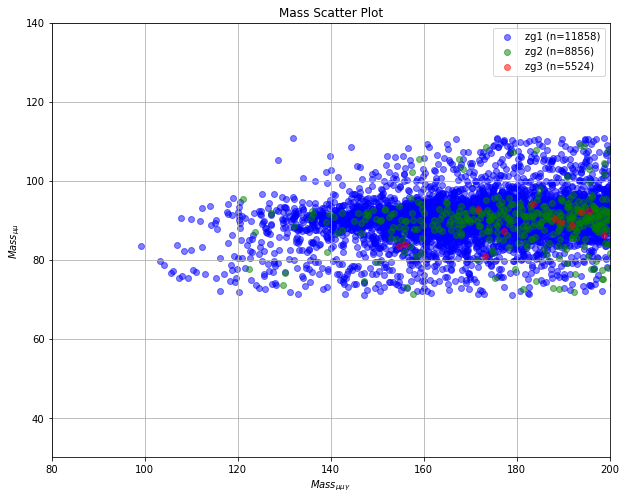

In [ ]:
keys_to_plot = ['zg1', 'zg2', 'zg3']
colors = ['b', 'g', 'r']

plt.figure(figsize=(10, 8))

for key, color in zip(keys_to_plot, colors):
    current_data = event_final[key]
    
    # 第一级判断
    mother1_pdg_ids = current_data['pdgid'][current_data['MotherIdx'][current_data['photonIdx']]]
    mask4 = (np.abs(mother1_pdg_ids) == 13)
    # mask1 = (np.abs(mother1_pdg_ids) != 11) & (np.abs(mother1_pdg_ids) != 13)
    
    # # mother id判断
    mother2 = current_data['MotherIdx'][current_data['photonIdx']]
    mask6 = (mother2 != -1)

    # # photon id判断
    id2 = current_data['photonIdx']
    mask7 = (id2 != -1)

    # mass muon 判断
    mask1 = current_data['muon_mass'] >= 71
    mask2 = current_data['muon_mass'] <= 111

    # dr cut
    mask3 = current_data['dr_lg'] >= 0

    
    # 测试
    # mask5 = current_data['gmumu_mass'] < 200

    # 创建综合掩码
    # final_mask = ak.flatten(mask1 & mask2 & mask3 )
    final_mask = mask1 & mask2 & ak.flatten(mask3)
    # final_mask = mask1 & mask2 & ak.flatten(mask4 & mask6 & mask7)
    # print(current_data['photonIdx'][final_mask])
    # print(current_data['MotherIdx'][current_data['photonIdx']][final_mask])
    # final_mask = ak.flatten(mask1)
    
    gmumu_mass = ak.to_numpy(current_data['gmumu_mass'][final_mask])
    muon_mass = ak.to_numpy(current_data['muon_mass'][final_mask])
    
    plt.scatter(gmumu_mass, muon_mass, alpha=0.5, color=color, label=key + ' (n=' + str(len(gmumu_mass)) + ')')

plt.title('Mass Scatter Plot')
plt.xlabel('$Mass_{\mu\mu\gamma}$')
plt.ylabel('$Mass_{\mu\mu}$')
plt.xlim(80,200)
plt.ylim(30,140)
plt.grid(True)
plt.legend(loc='best')
plt.show()


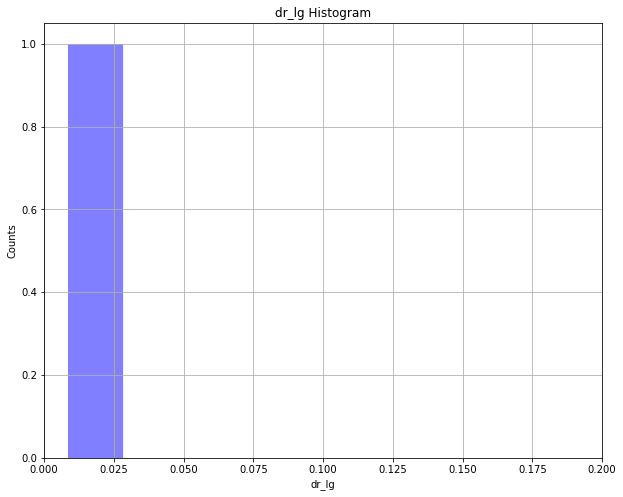

In [ ]:
keys_to_plot = ['zg1', 'zg2', 'zg3']
all_dr_lg = []

for key in keys_to_plot:
    current_data = event_final[key]
    
    # 第一级判断
    mother1_pdg_ids = current_data['pdgid'][current_data['MotherIdx'][current_data['photonIdx']]]
    mask1 = (np.abs(mother1_pdg_ids) == 13)
    
    # mother id判断
    mother2 = current_data['MotherIdx'][current_data['photonIdx']]
    mask2 = (mother2 != -1)

    # photon id判断
    id2 = current_data['photonIdx']
    mask3 = (id2 != -1)

    # 创建综合掩码
    final_mask = ak.flatten(mask1 & mask2 & mask3)
    
    # 提取满足条件的dr_lg值
    dr_lg = ak.to_numpy(current_data['dr_lg'][final_mask])
    
    # 添加到总数组中
    all_dr_lg.extend(dr_lg)

plt.figure(figsize=(10, 8))

all_dr_lg = np.concatenate(all_dr_lg)

# 绘制一维直方图
plt.hist(all_dr_lg, bins=50, color='b', alpha=0.5)

plt.title('dr_lg Histogram')
plt.xlabel('dr_lg')
plt.xlim(0,0.2)
plt.ylabel('Counts')
plt.grid(True)
plt.show()
